<a href="https://colab.research.google.com/github/California3/super-resolution-resize-cv/blob/main/esay_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package

In [455]:
!pip install chainer
!pip install tensorflow
!pip install opencv-python
!pip install opencv-python-headless
!pip install tqdm

In [456]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from chainer import Chain
from chainer import functions as F
from chainer import links as L
from keras import layers

In [457]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# DataSet

In [458]:
COLAB_SPACE   = True

In [459]:
if COLAB_SPACE:
    from google.colab import drive
    drive.mount('/content/drive')

    parents_loc = "/content/drive/MyDrive/ADV_CV_Code/"
    native_loc = "/content/native/"
    data_loc = native_loc + 'Dataset/Raw Data/'

    # if native_loc exists, then we are running on a local machine
    if os.path.exists(native_loc):
        print("Native location exists")
    else:
        # create native_loc
        os.mkdir(native_loc)
        # copy all files from parents_loc to native_loc
        !cp -r $parents_loc* $native_loc
        print("Copied files from parents_loc to native_loc")
else:
    parents_loc = ''
    data_loc = 'Dataset/Raw Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Native location exists


In [460]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
low_img = []

path = data_loc + 'high_res'
path_low = data_loc + 'low_res'

files = os.listdir(path)
files = sorted_alphanumeric(files)

files_low = os.listdir(path_low)
files_low = sorted_alphanumeric(files_low)
for i in tqdm(files):
    if i == '855.jpg':
        break
    elif i in files_low:
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

        img = cv2.imread(path_low + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:04<00:00, 171.71it/s]


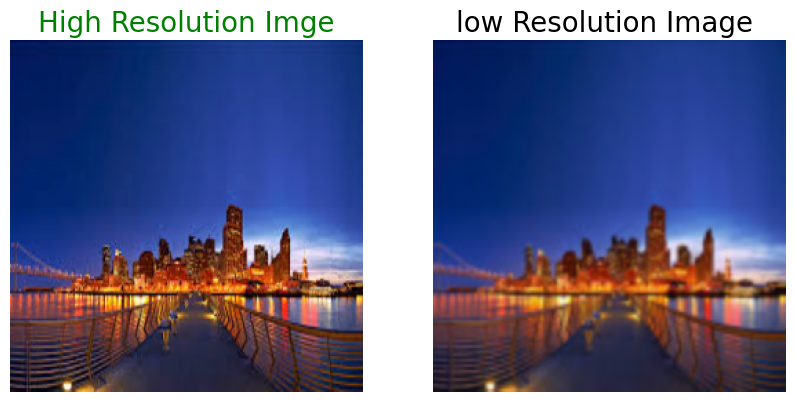

In [461]:
for i in range(1):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [462]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


# Models

In [463]:
# Keep default functions.
def down_default(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def up_default(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [464]:
# Our new functions.
def up_resize_conv(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()

    # upsample.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))
    # upsample.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))

    upsample.add(layers.UpSampling2D(size=(4, 4), data_format=None, interpolation='nearest'))

    upsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))

    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def down_upgrade(filters , kernel_size, apply_batch_normalization = True):
    return down_default(filters , kernel_size, apply_batch_normalization)

In [465]:
# New Interface For model
def upgrade(type = ""):
    upsample = tf.keras.models.Sequential()
    if type == "upgrade" or FORCE_UPGRADE:
        pass
    else:
        pass
    return upsample

def up(filters, kernel_size, dropout = False, type = ''):
    if type == 'resize_conv' or FORCE_UPGRADE:
        return up_resize_conv(filters, kernel_size, dropout)
    else:
        return up_default(filters, kernel_size, dropout)

def down(filters , kernel_size, apply_batch_normalization = True, type = ""):
    if type == "upgrade" or FORCE_UPGRADE:
        return down_upgrade(filters , kernel_size, apply_batch_normalization)
    else:
        return down_default(filters , kernel_size, apply_batch_normalization)

In [466]:
def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    # convolutions down the stack
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)

    # deconvolutions up the stack OR first upsampling then convolutions
    u1 = up(512,(3,3),False, "")(d5)
    d4_ = upgrade()(d4)
    u1 = layers.concatenate([u1,d4_])
    u2 = up(256,(3,3),False, "")(u1)
    d3_ = upgrade()(d3)
    u2 = layers.concatenate([u2,d3_])
    u3 = up(128,(3,3),False, "resize_conv")(u2)
    d2_ = upgrade()(d2)
    u3 = layers.concatenate([u3,d2_])
    u4 = up(128,(3,3),False, "resize_conv")(u3)
    d1_ = upgrade()(d1)
    u4 = layers.concatenate([u4,d1_])
    u5 = up(3,(3,3),False, "resize_conv")(u4)
    inputs_ = upgrade()(inputs)
    u5 = layers.concatenate([u5,inputs_])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [467]:
FORCE_UPGRADE = False
NEED_FITTING  = True
MODEL_NAME    = 'final_model'
MODEL_NAME    = 'final_model_resize_2-2'

if MODEL_NAME == "" or MODEL_NAME == "final_model":
    MODEL_PATH = parents_loc + "Model/final_model.h5"
else:
    MODEL_PATH = parents_loc + "Model/" + MODEL_NAME +".h5"

In [468]:
if NEED_FITTING or not os.path.exists(MODEL_PATH):
    model = model()
    # NEED_FITTING = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
                metrics = ['acc'])
    model.fit(train_low_image, train_high_image, epochs = 7, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))
    model.save(MODEL_PATH)
else:
    print("Load From Dir.")
    model = tf.keras.models.load_model(MODEL_PATH)

print("Model Name:", MODEL_NAME)

Epoch 1/7
700/700 [==============================] - 25s 29ms/step - loss: 0.0730 - acc: 0.5855 - val_loss: 0.0458 - val_acc: 0.7545
Epoch 2/7
700/700 [==============================] - 19s 28ms/step - loss: 0.0369 - acc: 0.7201 - val_loss: 0.0372 - val_acc: 0.7221
Epoch 3/7
700/700 [==============================] - 19s 28ms/step - loss: 0.0313 - acc: 0.7540 - val_loss: 0.0356 - val_acc: 0.7401
Epoch 4/7
700/700 [==============================] - 19s 28ms/step - loss: 0.0320 - acc: 0.7488 - val_loss: 0.0298 - val_acc: 0.7562
Epoch 5/7
700/700 [==============================] - 19s 28ms/step - loss: 0.0273 - acc: 0.7748 - val_loss: 0.0290 - val_acc: 0.7635
Epoch 6/7
700/700 [==============================] - 19s 28ms/step - loss: 0.0284 - acc: 0.7680 - val_loss: 0.0271 - val_acc: 0.7461
Epoch 7/7
700/700 [==============================] - 19s 28ms/step - loss: 0.0254 - acc: 0.7986 - val_loss: 0.0261 - val_acc: 0.8048
Model Name: final_model_resize_2-2


# Prediction Visualization

1/1 [==============================] - 0s 189ms/step


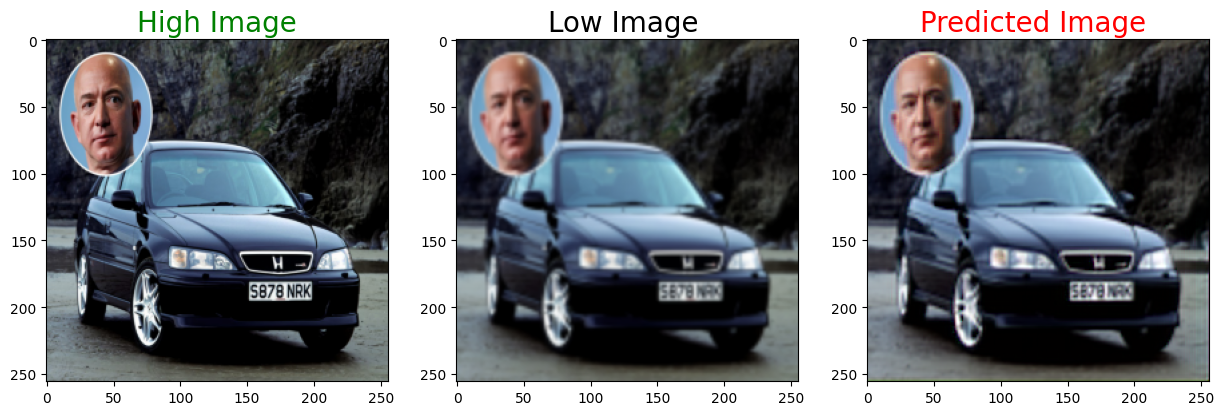

1/1 [==============================] - 0s 21ms/step


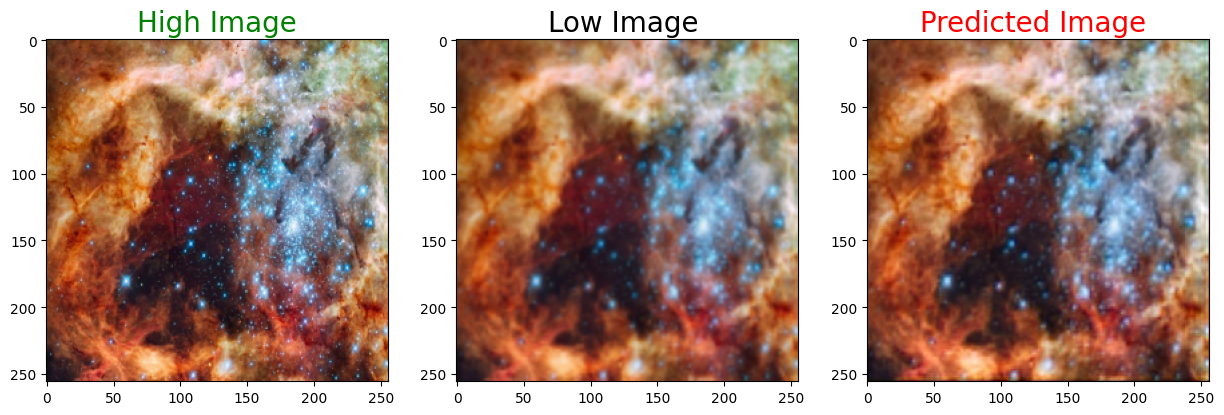

In [469]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

for i in range(1,3):
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

In [470]:
model.summary()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_417 (Sequential  (None, 128, 128, 128)        3584      ['input_30[0][0]']            
 )                                                                                                
                                                                                                  
 sequential_418 (Sequential  (None, 64, 64, 128)          147584    ['sequential_417[0][0]']      
 )                                                                                                
                                                                                           

In [471]:
# y_pred = []
# y_true = []

# for i in range(len(test_high_image)):
#     predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
#     y_pred.append(predicted)
#     y_true.append(test_high_image[i])

# y_pred = np.array(y_pred)
# y_true = np.array(y_true)

# y_pred = y_pred.reshape(y_pred.shape[0],-1)
# y_true = y_true.reshape(y_true.shape[0],-1)

# def calculate_results(y_true, y_pred):
#     y_pred_thresholded = y_pred > 0.5
#     true_positives = np.sum(y_true * y_pred_thresholded)



# loss, accuracy, f1_score, precision, recall = calculate_results(y_true, y_pred)
# print(f'Loss: {loss}')
# print(f'Accuracy: {accuracy}')
# print(f'F1 Score: {f1_score}')
# print(f'Precision: {precision}')